In [120]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import image
from keras import layers, models

In [10]:
def mkdir_if_not_exist(DIR):
    if not os.path.exists(DIR):
        os.mkdir(DIR)


In [48]:
DATASET_BASE_DIR = "C:\\Users\\kocam\\Downloads\\dogs-vs-cats"

DATASET_SAMPLE_BASE_DIR = "C:\\Users\\kocam\\Downloads\\dogs-vs-cats\\small"

os.listdir(DATASET_BASE_DIR)
mkdir_if_not_exist(DATASET_SAMPLE_BASE_DIR)

TRAIN_BASE_DIR = os.path.join(DATASET_SAMPLE_BASE_DIR, "train")
VALIDATION_BASE_DIR = os.path.join(DATASET_SAMPLE_BASE_DIR, "validation")
TEST_BASE_DIR = os.path.join(DATASET_SAMPLE_BASE_DIR,"test")

mkdir_if_not_exist(TRAIN_BASE_DIR)
mkdir_if_not_exist(VALIDATION_BASE_DIR)
mkdir_if_not_exist(TEST_BASE_DIR)


TRAIN_CATS_DIR = os.path.join(TRAIN_BASE_DIR, "cats")
TRAIN_DOGS_DIR = os.path.join(TRAIN_BASE_DIR, "dogs")

mkdir_if_not_exist(TRAIN_CATS_DIR)
mkdir_if_not_exist(TRAIN_DOGS_DIR)

VALIDATION_CATS_DIR = os.path.join(VALIDATION_BASE_DIR, "cats")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_BASE_DIR, "dogs")

mkdir_if_not_exist(VALIDATION_CATS_DIR)
mkdir_if_not_exist(VALIDATION_DOGS_DIR)

TEST_CATS_DIR = os.path.join(TEST_BASE_DIR, "cats")
TEST_DOGS_DIR = os.path.join(TEST_BASE_DIR, "dogs")

mkdir_if_not_exist(TEST_CATS_DIR)
mkdir_if_not_exist(TEST_DOGS_DIR)

In [22]:
def copy_files(fnames, src, dst):
    for fname in fnames:
        src_f = os.path.join(src, fname)
        dst_f = os.path.join(dst, fname)
        shutil.copyfile(src_f, dst_f)

In [46]:
def generate_fnames(type, start, end):
    return ["{0}.{1}.jpg".format(type, i) for i in range(start, end)]

In [49]:
copy_files(generate_fnames("cat", 0, 1000), os.path.join(DATASET_BASE_DIR, "train"), TRAIN_CATS_DIR)
copy_files(generate_fnames("cat", 1000, 1500), os.path.join(DATASET_BASE_DIR, "train"), VALIDATION_CATS_DIR)
copy_files(generate_fnames("cat", 1500, 2000), os.path.join(DATASET_BASE_DIR, "train"), TEST_CATS_DIR)

copy_files(generate_fnames("dog", 0, 1000), os.path.join(DATASET_BASE_DIR, "train"), TRAIN_DOGS_DIR)
copy_files(generate_fnames("dog", 1000, 1500), os.path.join(DATASET_BASE_DIR, "train"), VALIDATION_DOGS_DIR)
copy_files(generate_fnames("dog", 1500, 2000), os.path.join(DATASET_BASE_DIR, "train"), TEST_DOGS_DIR)

In [56]:
train_cats_fnames = os.listdir(TRAIN_CATS_DIR)

In [60]:
im = image.imread(os.path.join(TRAIN_CATS_DIR, train_cats_fnames[100]))

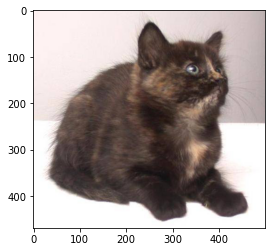

In [61]:
plt.imshow(im)

In [166]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_BASE_DIR,
    label_mode="binary",
    batch_size=20,
    image_size=(150, 150)
)

validation_dataset= tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_BASE_DIR,
    label_mode="binary",
    batch_size=20,
    image_size=(150, 150)
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [167]:
train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [125]:
train_dataset.class_names

['cats', 'dogs']

In [126]:
train_dataset.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=100>

In [127]:
for data_batch, label_batch in train_dataset:
    print("Data Batch Shape: {0}".format(data_batch.shape))
    print("Label Batch Shape: {0}".format(label_batch.shape))
    break

Data Batch Shape: (20, 150, 150, 3)
Label Batch Shape: (20, 1)


In [121]:
normalization_layer = layers.Rescaling(1./255)

In [168]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val = validation_dataset.map(lambda x,y: (normalization_layer(x), y))

In [131]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [134]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [140]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),loss="binary_crossentropy",metrics=["accuracy"])

In [141]:
history = model.fit(
    x=normalized_ds,
    steps_per_epoch=100,
    epochs=30,
    validation_data=normalized_val,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 10s 32ms/step - loss: 0.6867 - accuracy: 0.5320 - val_loss: 0.6867 - val_accuracy: 0.5170
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 0.6492 - accuracy: 0.6310 - val_loss: 0.6511 - val_accuracy: 0.6040
Epoch 3/30
100/100 [==============================] - 3s 27ms/step - loss: 0.6097 - accuracy: 0.6695 - val_loss: 0.6348 - val_accuracy: 0.6210
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5682 - accuracy: 0.7165 - val_loss: 0.5906 - val_accuracy: 0.6760
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5343 - accuracy: 0.7225 - val_loss: 0.6182 - val_accuracy: 0.6800
Epoch 6/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5077 - accuracy: 0.7480 - val_loss: 0.6486 - val_accuracy: 0.6600
Epoch 7/30
100/100 [==============================] - 3s 27ms/step - loss: 0.4837 - accuracy: 0.7625 - val_loss: 0.5659 - val_accuracy: 0.698

In [142]:
model.save("cats_and_dogs_small_1.h5")

In [143]:
history_dict = history.history

In [145]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [147]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

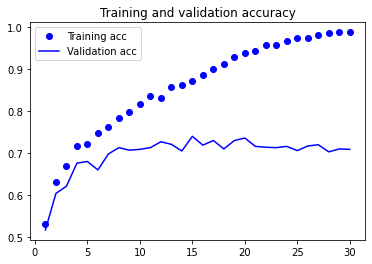

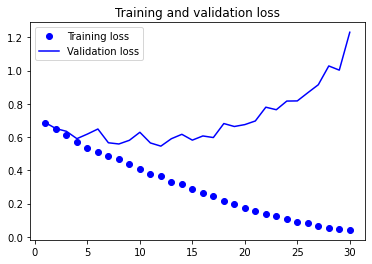

In [150]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [152]:
data_augmentation = models.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomBrightness((-0.4, 0.7)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.3, 0.4)
    ])

In [169]:
augmented_ds = normalized_ds.map(lambda x, y: (data_augmentation(x), y))

In [170]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [171]:
model.compile(optimizer="adam",loss="binary_crossentropy", metrics=["accuracy"])

In [178]:
history = model.fit(
    x=augmented_ds,
    steps_per_epoch=100,
    epochs=100,
    validation_data=normalized_val,
    validation_steps=50
)

Epoch 1/100
 55/100 [===============>..............] - ETA: 2s - loss: 0.6934 - accuracy: 0.4909

KeyboardInterrupt: 

In [173]:
model.save("./cats_and_dogs_small_2.h5")

In [176]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

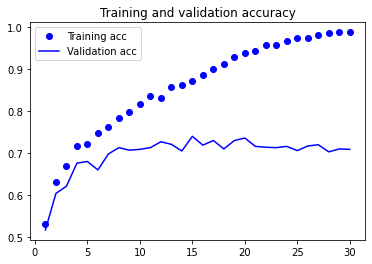

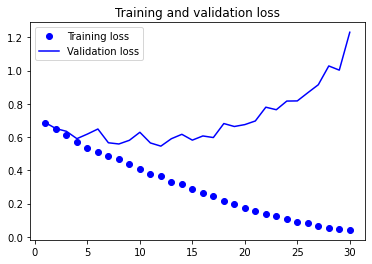

In [177]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()